In [3]:
#keep_samples <- c("Low-grade glioma", "High-grade glioma", "Glioblastoma")
keep_samples <- c('Glioblastoma')

In [3]:
library(Seurat)
library(harmony)


Loading required package: SeuratObject

Loading required package: sp

'SeuratObject' was built with package 'Matrix' 1.7.0 but the current
version is 1.7.1; it is recomended that you reinstall 'SeuratObject' as
the ABI for 'Matrix' may have changed


Attaching package: 'SeuratObject'


The following objects are masked from 'package:base':

    intersect, t


Warning message:
"package 'harmony' was built under R version 4.4.1"
Loading required package: Rcpp

Warning message:
"package 'Rcpp' was built under R version 4.4.1"


In [ ]:

data_list <- readRDS(file.path(dir = "out", filename = "clean_data.rds"))


In [2]:
for (name in names(data_list)) {
    cat(name, unique(data_list[[name]]@meta.data$diagnosis), nrow(data_list[[name]]@meta.data), "\n")
}

GSM8375832_GBM1_L Glioblastoma 4736 
GSM8375833_GBM3_Y Glioblastoma 10555 
GSM8375834_GBM4_W Glioblastoma 13295 
GSM8375835_GBM5_L Glioblastoma 5445 
GSM8375836_GBM6_X Glioblastoma 3990 
SCPCS000002 Glioblastoma 1551 
SCPCS000003 Glioblastoma 1048 
SCPCS000006 Glioblastoma 2327 
SCPCS000007 Glioblastoma 2138 
SCPCS000008 Glioblastoma 7849 
SCPCS000009 Glioblastoma 2477 
SCPCS000010 Glioblastoma 289 
SCPCS000013 Glioblastoma 4791 
SCPCS000014 Glioblastoma 931 
SCPCS000015 Glioblastoma 2489 
SCPCS000017 Glioblastoma 1093 
SCPCS000018 Glioblastoma 48 
SCPCS000019 Glioblastoma 2247 
SCPCS000020 Glioblastoma 643 
SCPCS000022 Glioblastoma 699 
SCPCS000023 Glioblastoma 2954 


In [73]:
selected_list <- list()
for (name in names(data_list)) {
  grades <- unique(data_list[[name]]@meta.data$diagnosis)
  if (any(grades %in% keep_samples)) {
    selected_list[[name]] <- data_list[[name]]
  }
}
selected_list

$GSM8375832_GBM1_L
An object of class Seurat 
33694 features across 4736 samples within 1 assay 
Active assay: RNA (33694 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

$GSM8375833_GBM3_Y
An object of class Seurat 
33694 features across 10555 samples within 1 assay 
Active assay: RNA (33694 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

$GSM8375834_GBM4_W
An object of class Seurat 
33694 features across 13295 samples within 1 assay 
Active assay: RNA (33694 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

$GSM8375835_GBM5_L
An object of class Seurat 
33694 features across 5445 samples within 1 assay 
Active assay: RNA (33694 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

$G

In [69]:
library(Seurat)
library(AnnotationDbi)
library(org.Hs.eg.db)  # Change to org.Mm.eg.db for Mouse
library(dplyr)

In [71]:
convert_ensembl_to_symbol <- function(ensembl_ids, species = "hsapiens") {
  # Select the appropriate OrgDb based on species
  if (species == "hsapiens") {
    orgdb <- org.Hs.eg.db
  } else if (species == "mmusculus") {
    orgdb <- org.Mm.eg.db
  } else {
    stop("Species not supported. Please use 'hsapiens' or 'mmusculus'.")
  }
  
  # Remove version numbers from Ensembl IDs (e.g., ENSG000001234.5 -> ENSG000001234)
  ensembl_ids_clean <- sub("\\..*", "", ensembl_ids)
  
  # Map Ensembl IDs to gene symbols
  gene_symbols <- mapIds(
    orgdb,
    keys = ensembl_ids_clean,
    column = "SYMBOL",
    keytype = "ENSEMBL",
    multiVals = "first"  # Use the first symbol if multiple are found
  )
  
  return(gene_symbols)
}


In [75]:

# Iterate through each Seurat object in selected_list
for (name in names(selected_list)) {
  seurat_obj <- selected_list[[name]]
  
  # Get current gene identifiers
  genes <- rownames(seurat_obj)
  
  # Check if genes are Ensembl IDs (assuming Ensembl IDs start with "ENSG")
  if (any(grepl("^ENSG", genes))) {
    message(paste("Converting Ensembl IDs to gene symbols in", name))
    
    # Convert Ensembl IDs to gene symbols
    gene_symbols <- convert_ensembl_to_symbol(genes, species = "hsapiens")  # Change species if needed
    
    # Identify genes with valid gene symbols
    valid_genes <- !is.na(gene_symbols) & gene_symbols != ""
    
    if (sum(valid_genes) == 0) {
      warning(paste("No valid gene symbols found for", name, ". Skipping this object."))
      next
    }
    
    # Subset Seurat object to keep only valid genes
    seurat_obj_subset <- subset(seurat_obj, features = genes[valid_genes])
    gene_symbols_subset <- gene_symbols[valid_genes]
    
    # Get the counts matrix
    counts_matrix <- GetAssayData(seurat_obj_subset, slot = "counts")
    
    # Replace rownames with gene symbols
    rownames(counts_matrix) <- gene_symbols_subset
    
    # Handle duplicate gene symbols by summing their counts
    # Convert to data frame for manipulation
    counts_df <- as.data.frame(counts_matrix)
    counts_df$gene_symbol <- rownames(counts_matrix)
    
    # Aggregate counts by gene symbol
    counts_aggregated <- counts_df %>%
      group_by(gene_symbol) %>%
      summarise(across(everything(), sum)) %>%
      ungroup()
    
    # Convert back to a matrix
    counts_matrix_aggregated <- as.matrix(counts_aggregated[,-1])
    rownames(counts_matrix_aggregated) <- counts_aggregated$gene_symbol
    
    # Create a new Seurat object with the aggregated counts
    seurat_obj_aggregated <- CreateSeuratObject(
      counts = counts_matrix_aggregated,
      meta.data = seurat_obj_subset@meta.data
    )
    
    # Transfer additional assay data if necessary
    # For example, if you have normalized data, variable features, etc.
    # This step can be more complex depending on your specific data and requirements
    
    # Replace the original Seurat object with the aggregated one
    selected_list[[name]] <- seurat_obj_aggregated
    message(paste("Conversion and aggregation completed for", name))
    
  } else {
    message(paste(name, "already uses gene symbols. No conversion needed."))
  }
}

GSM8375832_GBM1_L already uses gene symbols. No conversion needed.

GSM8375833_GBM3_Y already uses gene symbols. No conversion needed.

GSM8375834_GBM4_W already uses gene symbols. No conversion needed.

GSM8375835_GBM5_L already uses gene symbols. No conversion needed.

GSM8375836_GBM6_X already uses gene symbols. No conversion needed.

Converting Ensembl IDs to gene symbols in SCPCS000002

'select()' returned 1:many mapping between keys and columns

Warning message:
"Data is of class matrix. Coercing to dgCMatrix."
Conversion and aggregation completed for SCPCS000002

Converting Ensembl IDs to gene symbols in SCPCS000003

'select()' returned 1:many mapping between keys and columns

Warning message:
"Data is of class matrix. Coercing to dgCMatrix."
Conversion and aggregation completed for SCPCS000003

Converting Ensembl IDs to gene symbols in SCPCS000006

'select()' returned 1:many mapping between keys and columns

Warning message:
"Data is of class matrix. Coercing to dgCMatrix."
Con

In [76]:
tail(rownames(selected_list[[1]]))
tail(rownames(selected_list[[10]]))

[1] "AC004556.1" "AC233755.2" "AC233755.1" "AC240274.1" "AC213203.1"
[6] "FAM231B"

[1] "ZXDC"   "ZYG11A" "ZYG11B" "ZYX"    "ZZEF1"  "ZZZ3"

In [77]:
lapply(selected_list, function(obj) {
  sum(duplicated(rownames(obj)))
})


$GSM8375832_GBM1_L
[1] 0

$GSM8375833_GBM3_Y
[1] 0

$GSM8375834_GBM4_W
[1] 0

$GSM8375835_GBM5_L
[1] 0

$GSM8375836_GBM6_X
[1] 0

$SCPCS000002
[1] 0

$SCPCS000003
[1] 0

$SCPCS000006
[1] 0

$SCPCS000007
[1] 0

$SCPCS000008
[1] 0

$SCPCS000009
[1] 0

$SCPCS000010
[1] 0

$SCPCS000013
[1] 0

$SCPCS000014
[1] 0

$SCPCS000015
[1] 0

$SCPCS000017
[1] 0

$SCPCS000018
[1] 0

$SCPCS000019
[1] 0

$SCPCS000020
[1] 0

$SCPCS000022
[1] 0

$SCPCS000023
[1] 0

In [78]:
features_list <- lapply(selected_list, rownames)
common_features <- Reduce(intersect, features_list)
print(lengths(features_list))
print(length(common_features))


GSM8375832_GBM1_L GSM8375833_GBM3_Y GSM8375834_GBM4_W GSM8375835_GBM5_L 
            33694             33694             33694             33694 
GSM8375836_GBM6_X       SCPCS000002       SCPCS000003       SCPCS000006 
            33694             18893             12396             19378 
      SCPCS000007       SCPCS000008       SCPCS000009       SCPCS000010 
            18597             19346             17347             15895 
      SCPCS000013       SCPCS000014       SCPCS000015       SCPCS000017 
            18497             17854             19476             18170 
      SCPCS000018       SCPCS000019       SCPCS000020       SCPCS000022 
             5362             20018             16910             17518 
      SCPCS000023 
            18838 
[1] 4695


In [80]:
# Remove SCPCS000018 using setdiff to exclude its name
selected_list <- selected_list[ setdiff(names(selected_list), "SCPCS000018") ]


In [79]:

# Normalize data and find variable features for each Seurat object
for (name in names(selected_list)) {
  selected_list[[name]] <- NormalizeData(selected_list[[name]], verbose = FALSE)
  selected_list[[name]] <- FindVariableFeatures(selected_list[[name]], selection.method = "vst", nfeatures = 2000, verbose = FALSE)
}


In [83]:
saveRDS(selected_list, "./out/selected_list.rds")

In [4]:
selected_list <- readRDS("./out/selected_list.rds")

In [5]:

# Select integration features
integration_features <- SelectIntegrationFeatures(object.list = selected_list, nfeatures = 2000)


In [6]:

# Merge all datasets
combined <- merge(selected_list[[1]], y = selected_list[2:length(selected_list)], 
                 add.cell.ids = names(selected_list))

# Scale data and run PCA
combined <- ScaleData(combined, features = integration_features, verbose = FALSE)
combined <- RunPCA(combined, features = integration_features, verbose = FALSE)
print(combined)

An object of class Seurat 
38488 features across 71547 samples within 1 assay 
Active assay: RNA (38488 features, 2000 variable features)
 46 layers present: counts.1, counts.2, counts.3, counts.4, counts.5, counts.6, counts.7, counts.8, counts.9, counts.10, counts.11, counts.12, counts.13, counts.14, counts.15, counts.16, counts.17, counts.18, counts.19, counts.20, data.1, scale.data.1, data.2, scale.data.2, data.3, scale.data.3, data.4, scale.data.4, data.5, scale.data.5, data.6, data.7, data.8, data.9, data.10, data.11, data.12, data.13, data.14, data.15, data.16, data.17, data.18, data.19, data.20, scale.data
 1 dimensional reduction calculated: pca


In [7]:
head(combined@meta.data)
unique(combined@meta.data$diagnosis)

,orig.ident,nCount_RNA,nFeature_RNA,sample_name,diagnosis,age,sex,tissue_location,RNA_snn_res.0.5,seurat_clusters,doublet_label,doublet_score,percent.mt
,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
GSM8375832_GBM1_L_AAACCTGAGACAGACC-1,GSM8375832_GBM1_L,9492,3346,GSM8375832_GBM1_L,Glioblastoma,NA,NA,NA,3,3,Singlet,0.1990291,1.8436578
GSM8375832_GBM1_L_AAACCTGAGACTTTCG-1,GSM8375832_GBM1_L,1751,1189,GSM8375832_GBM1_L,Glioblastoma,NA,NA,NA,2,2,Singlet,0.0736246,12.9069103
GSM8375832_GBM1_L_AAACCTGAGGCTATCT-1,GSM8375832_GBM1_L,2684,1698,GSM8375832_GBM1_L,Glioblastoma,NA,NA,NA,12,12,Singlet,0.2224919,2.2354694
GSM8375832_GBM1_L_AAACCTGAGTGAAGAG-1,GSM8375832_GBM1_L,5594,2974,GSM8375832_GBM1_L,Glioblastoma,NA,NA,NA,2,2,Singlet,0.1723301,6.3997140
GSM8375832_GBM1_L_AAACCTGAGTGCGTGA-1,GSM8375832_GBM1_L,4956,2478,GSM8375832_GBM1_L,Glioblastoma,NA,NA,NA,5,5,Singlet,0.2718447,0.5851493
GSM8375832_GBM1_L_AAACCTGAGTGTACTC-1,GSM8375832_GBM1_L,14145,4849,GSM8375832_GBM1_L,Glioblastoma,NA,NA,NA,6,6,Singlet,0.1933657,3.6267232


[1] "Glioblastoma"

In [8]:

# Run Harmony integration
combined <- RunHarmony(
  object = combined,
  group.by.vars = "sample_name", 
  assay.use = "RNA",
  reduction.use = "pca",
  dims.use = 1:20,
  verbose = TRUE
)

# Run UMAP on harmony embeddings
combined <- RunUMAP(combined, reduction = "harmony", dims = 1:20)
saveRDS(combined, file = "./out/integrated_harmony.rds")


Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony converged after 9 iterations

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
19:47:20 UMAP embedding parameters a = 0.9922 b = 1.112

19:47:20 Read 71547 rows and found 20 numeric columns

19:47:20 Using Annoy for neighbor search, n_neighbors = 30

19:47:20 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:47:25 Writing

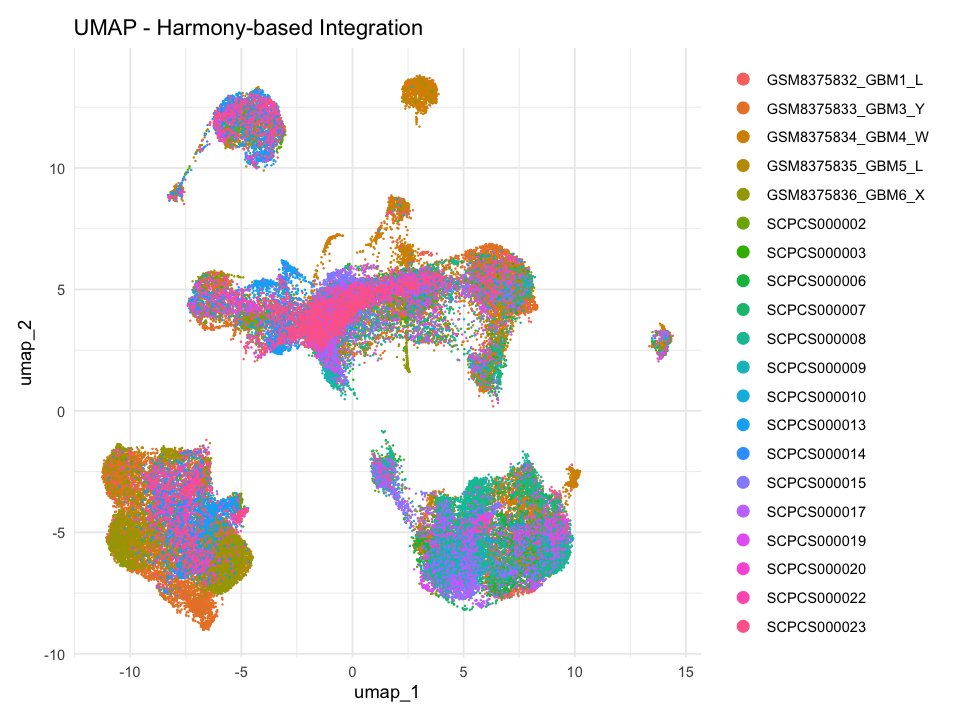

In [14]:
options(repr.plot.width=8, repr.plot.height=6)

library(ggplot2)

# Create and save UMAP plot
p <- DimPlot(combined, reduction = "umap", group.by = "sample_name") +
  ggtitle("UMAP - Harmony-based Integration") +
  theme_minimal()

ggsave(
  filename = file.path("./out/fig", "Harmony_based_Integration_UMAP_Sample_Name.png"),
  plot = p,
  width = 8,
  height = 6
)

# Display the plot
print(p)


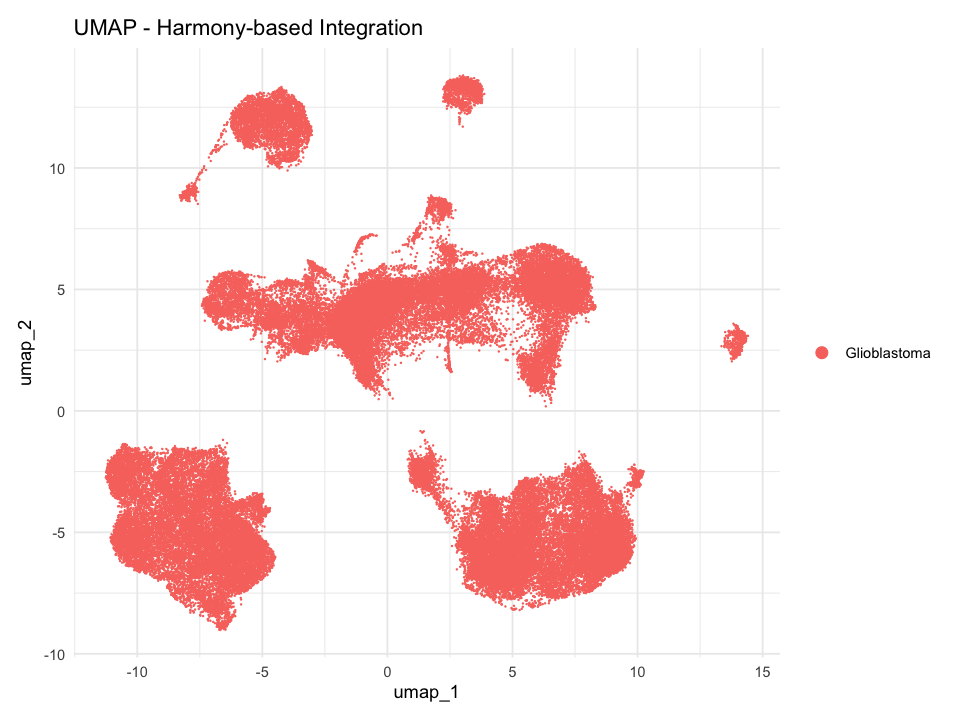

In [15]:

options(repr.plot.width=8, repr.plot.height=6)

library(ggplot2)

# Create and save UMAP plot
p <- DimPlot(combined, reduction = "umap", group.by = "diagnosis") +
  ggtitle("UMAP - Harmony-based Integration") +
  theme_minimal()

ggsave(
  filename = file.path("./out/fig", "Harmony_based_Integration.png"),
  plot = p,
  width = 8,
  height = 6
)

# Display the plot
print(p)

In [16]:
table(combined@meta.data$diagnosis)


Glioblastoma 
       71547 